# NYC Traffic Collisions - Visualizations & KPIs Dashboard
**Students:** רועי בנימיני, עוז ניסנבוים

**Purpose:** Additional visualizations and KPI summaries for the Data Mining project.

---
> ⚠️ **Note:** This notebook requires running `ML2.ipynb` first, or loading the data independently.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load data
url = "https://github.com/Roybin12/machine-learning-2-project/raw/main/VRU_Crashes_Sample.zip"
df = pd.read_csv(url, compression='zip')

# Create target variable
df['TARGET'] = np.where(
    (df['NUMBER OF PEDESTRIANS INJURED'] > 0) | (df['NUMBER OF PEDESTRIANS KILLED'] > 0), 
    0, 1
)

# Create temporal features
df['CRASH_DATETIME'] = pd.to_datetime(df['CRASH DATE'] + ' ' + df['CRASH TIME'])
df['HOUR'] = df['CRASH_DATETIME'].dt.hour
df['DAY_OF_WEEK'] = df['CRASH_DATETIME'].dt.dayofweek
df['MONTH'] = df['CRASH_DATETIME'].dt.month
df['YEAR'] = df['CRASH_DATETIME'].dt.year
df['IS_WEEKEND'] = (df['DAY_OF_WEEK'] >= 5).astype(int)

print(f"✅ Data loaded: {len(df):,} records")
print(f"   Pedestrians: {(df['TARGET']==0).sum():,} ({(df['TARGET']==0).mean()*100:.1f}%)")
print(f"   Cyclists: {(df['TARGET']==1).sum():,} ({(df['TARGET']==1).mean()*100:.1f}%)")

✅ Data loaded: 192,707 records
   Pedestrians: 128,796 (66.8%)
   Cyclists: 63,911 (33.2%)


## 1. KPIs Dashboard
Summary of all key performance indicators in one view.

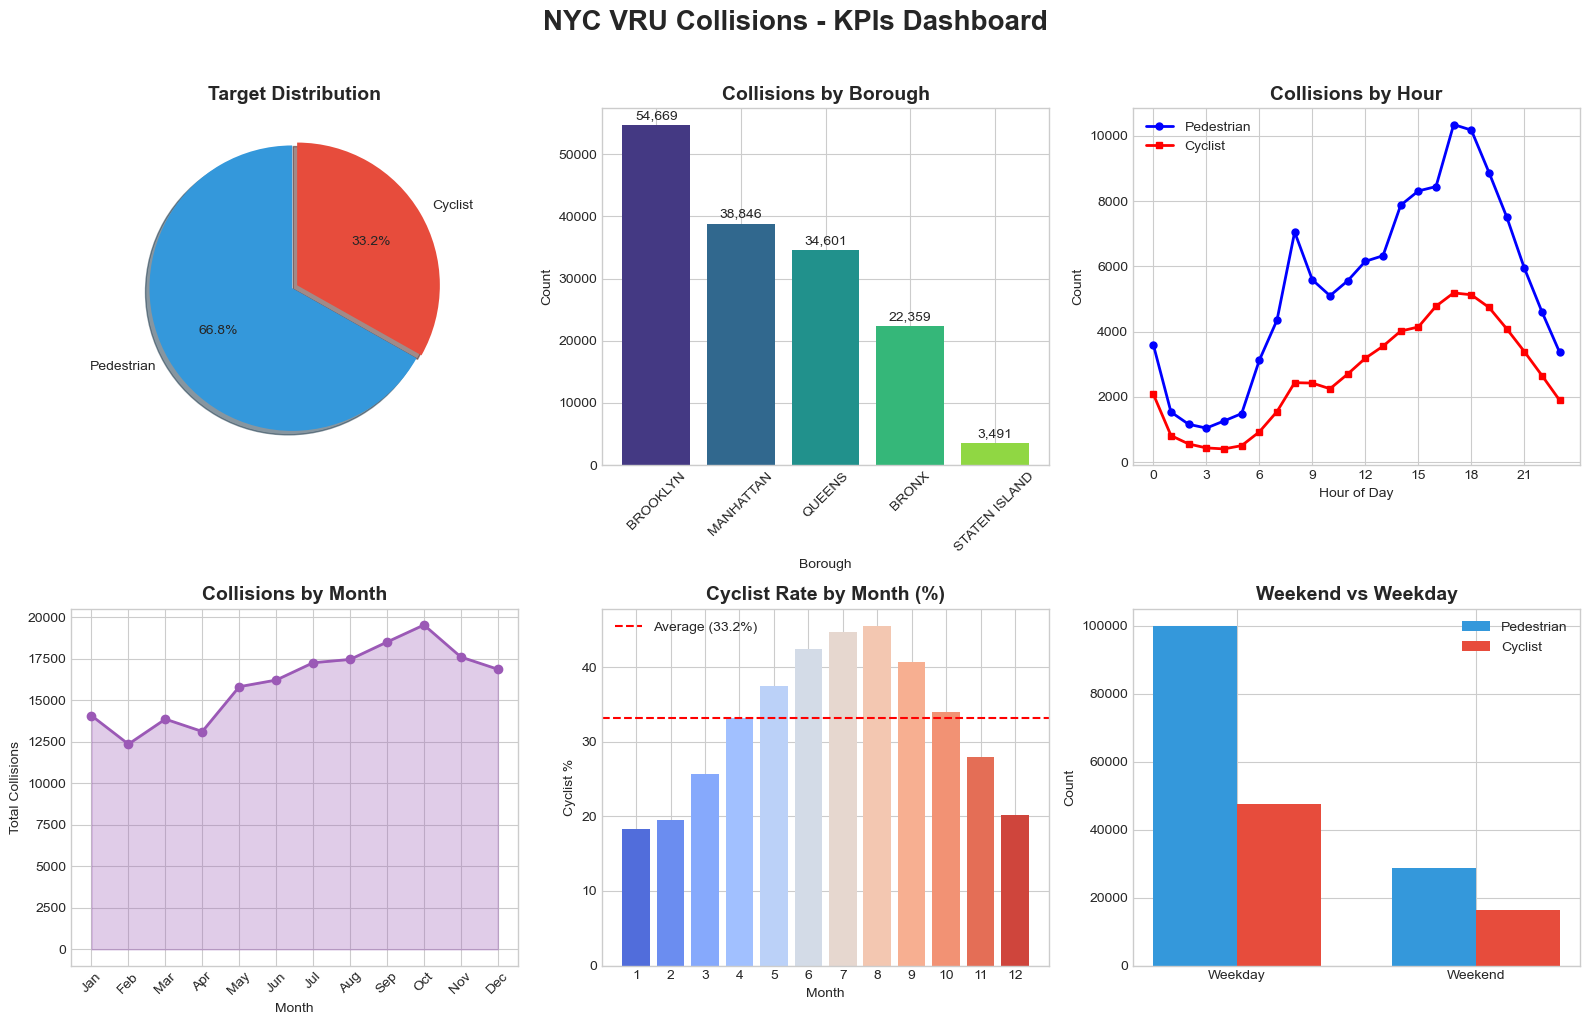

In [2]:
# KPIs Dashboard
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('NYC VRU Collisions - KPIs Dashboard', fontsize=20, fontweight='bold', y=1.02)

# KPI 1: Target Distribution (Pie)
ax1 = axes[0, 0]
target_counts = df['TARGET'].value_counts()
colors = ['#3498db', '#e74c3c']
ax1.pie(target_counts, labels=['Pedestrian', 'Cyclist'], autopct='%1.1f%%', 
        colors=colors, explode=(0.02, 0.02), shadow=True, startangle=90)
ax1.set_title('Target Distribution', fontsize=14, fontweight='bold')

# KPI 2: Collisions by Borough (Bar)
ax2 = axes[0, 1]
borough_counts = df['BOROUGH'].value_counts().head(5)
bars = ax2.bar(borough_counts.index, borough_counts.values, color=sns.color_palette("viridis", 5))
ax2.set_title('Collisions by Borough', fontsize=14, fontweight='bold')
ax2.set_xlabel('Borough')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)
for bar, val in zip(bars, borough_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, f'{val:,}', 
             ha='center', va='bottom', fontsize=10)

# KPI 3: Hourly Distribution (Line)
ax3 = axes[0, 2]
hourly_ped = df[df['TARGET']==0].groupby('HOUR').size()
hourly_cyc = df[df['TARGET']==1].groupby('HOUR').size()
ax3.plot(hourly_ped.index, hourly_ped.values, 'b-o', label='Pedestrian', linewidth=2, markersize=5)
ax3.plot(hourly_cyc.index, hourly_cyc.values, 'r-s', label='Cyclist', linewidth=2, markersize=5)
ax3.set_title('Collisions by Hour', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Count')
ax3.legend()
ax3.set_xticks(range(0, 24, 3))

# KPI 4: Monthly Trend (Area)
ax4 = axes[1, 0]
monthly = df.groupby('MONTH')['TARGET'].agg(['count', 'mean'])
ax4.fill_between(monthly.index, monthly['count'], alpha=0.3, color='#9b59b6')
ax4.plot(monthly.index, monthly['count'], 'o-', color='#9b59b6', linewidth=2)
ax4.set_title('Collisions by Month', fontsize=14, fontweight='bold')
ax4.set_xlabel('Month')
ax4.set_ylabel('Total Collisions')
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# KPI 5: Cyclist Rate by Month (Bar)
ax5 = axes[1, 1]
cyclist_rate = df.groupby('MONTH')['TARGET'].mean() * 100
bars = ax5.bar(cyclist_rate.index, cyclist_rate.values, color=sns.color_palette("coolwarm", 12))
ax5.axhline(y=df['TARGET'].mean()*100, color='red', linestyle='--', label=f'Average ({df["TARGET"].mean()*100:.1f}%)')
ax5.set_title('Cyclist Rate by Month (%)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Month')
ax5.set_ylabel('Cyclist %')
ax5.legend()
ax5.set_xticks(range(1, 13))

# KPI 6: Weekend vs Weekday (Grouped Bar)
ax6 = axes[1, 2]
weekend_data = df.groupby(['IS_WEEKEND', 'TARGET']).size().unstack()
x = np.arange(2)
width = 0.35
bars1 = ax6.bar(x - width/2, weekend_data[0], width, label='Pedestrian', color='#3498db')
bars2 = ax6.bar(x + width/2, weekend_data[1], width, label='Cyclist', color='#e74c3c')
ax6.set_title('Weekend vs Weekday', fontsize=14, fontweight='bold')
ax6.set_xlabel('')
ax6.set_ylabel('Count')
ax6.set_xticks(x)
ax6.set_xticklabels(['Weekday', 'Weekend'])
ax6.legend()

plt.tight_layout()
plt.savefig('kpi_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Heatmap - Collisions by Hour and Day

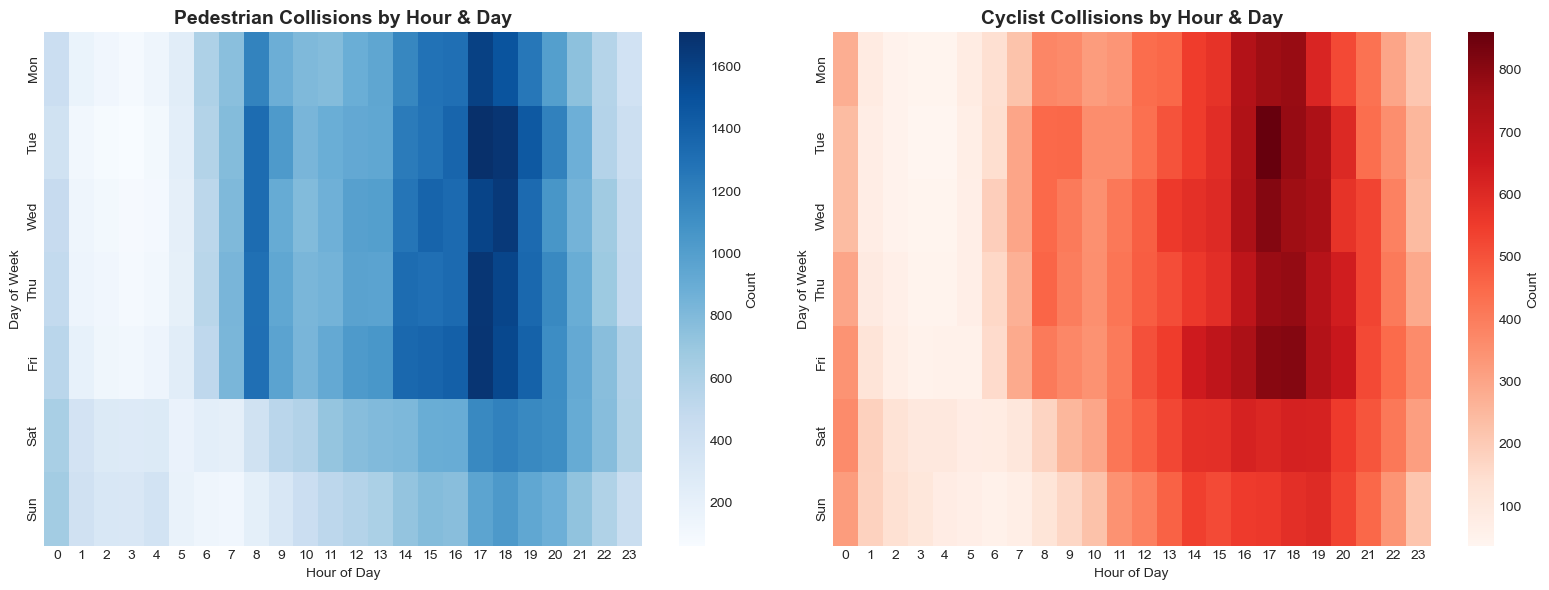

In [3]:
# Heatmap: Hour vs Day of Week
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pedestrian heatmap
pivot_ped = df[df['TARGET']==0].groupby(['DAY_OF_WEEK', 'HOUR']).size().unstack(fill_value=0)
sns.heatmap(pivot_ped, cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Pedestrian Collisions by Hour & Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Day of Week')
axes[0].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Cyclist heatmap
pivot_cyc = df[df['TARGET']==1].groupby(['DAY_OF_WEEK', 'HOUR']).size().unstack(fill_value=0)
sns.heatmap(pivot_cyc, cmap='Reds', ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Cyclist Collisions by Hour & Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Day of Week')
axes[1].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout()
plt.savefig('heatmap_hour_day.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Model Comparison - Radar Chart

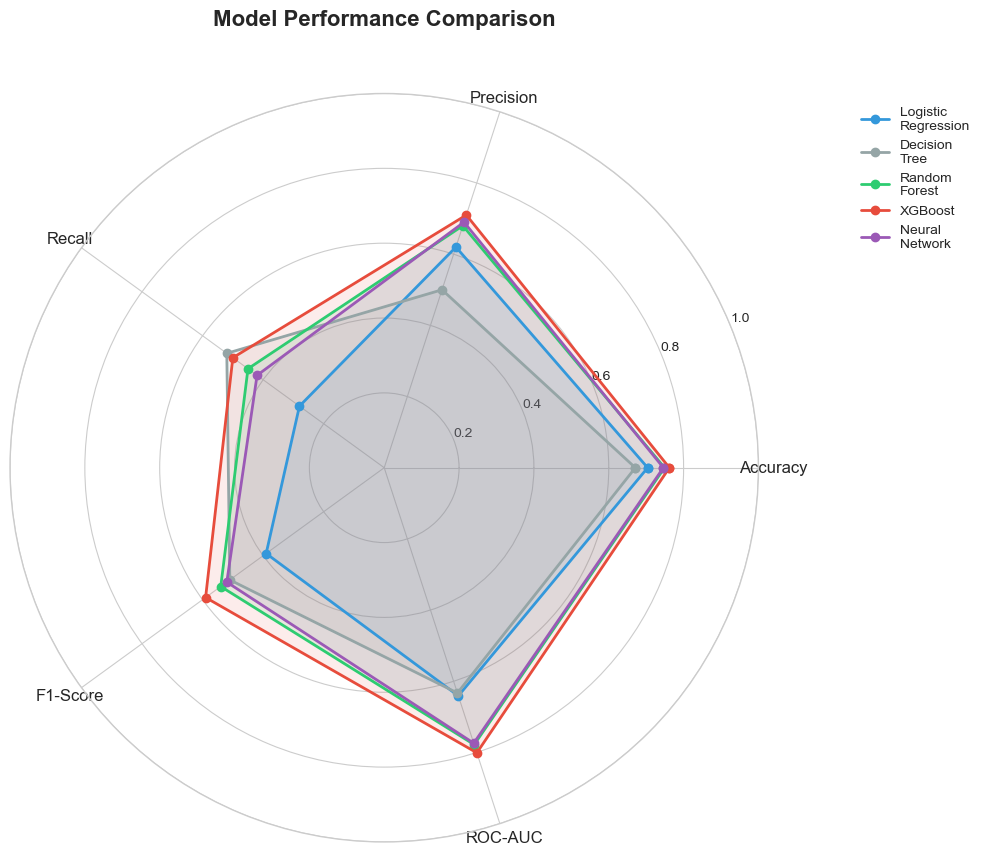

In [4]:
# Model performance data (from ML2.ipynb results)
models = ['Logistic\nRegression', 'Decision\nTree', 'Random\nForest', 'XGBoost', 'Neural\nNetwork']
metrics = {
    'Accuracy': [0.704, 0.671, 0.749, 0.762, 0.746],
    'Precision': [0.62, 0.50, 0.68, 0.71, 0.69],
    'Recall': [0.28, 0.52, 0.45, 0.50, 0.42],
    'F1-Score': [0.39, 0.51, 0.54, 0.59, 0.52],
    'ROC-AUC': [0.641, 0.633, 0.778, 0.801, 0.774]
}

# Radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

categories = list(metrics.keys())
num_vars = len(categories)
angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]

colors = ['#3498db', '#95a5a6', '#2ecc71', '#e74c3c', '#9b59b6']

for i, model in enumerate(models):
    values = [metrics[cat][i] for cat in categories]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('radar_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Geographic Analysis - Borough Comparison

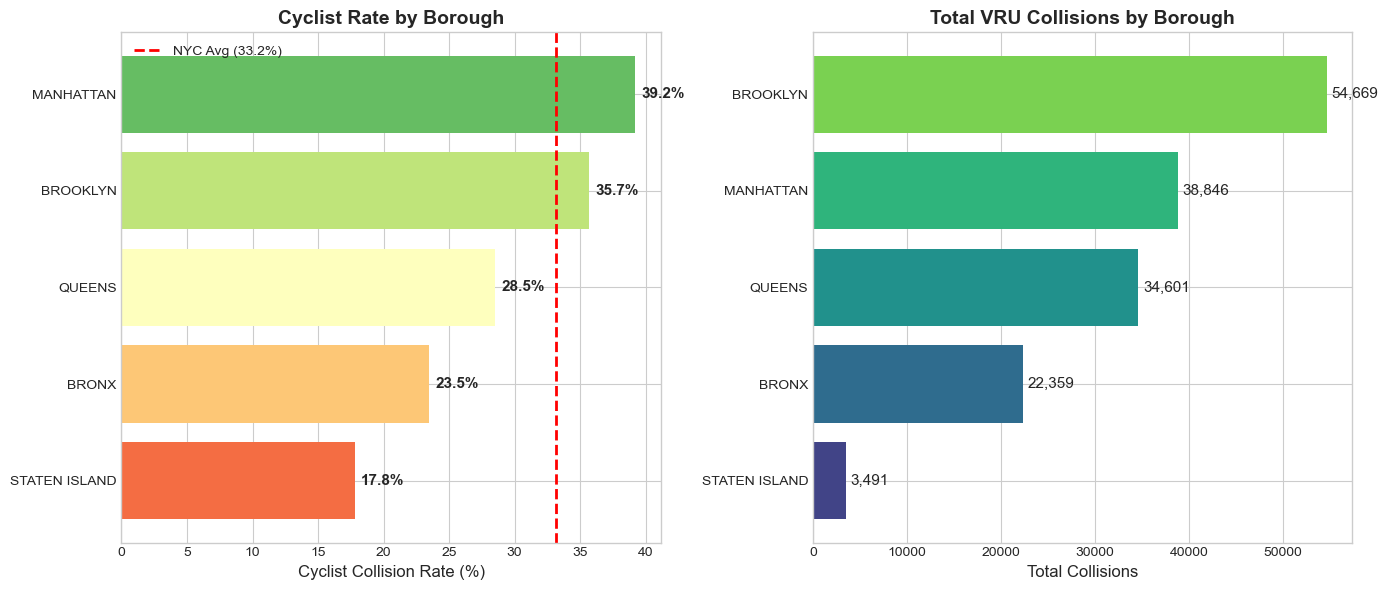

In [5]:
# Borough analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Cyclist rate by borough
borough_stats = df.groupby('BOROUGH').agg({
    'TARGET': ['count', 'mean']
}).round(3)
borough_stats.columns = ['Total', 'Cyclist_Rate']
borough_stats = borough_stats.sort_values('Cyclist_Rate', ascending=True)

# Plot 1: Cyclist rate
ax1 = axes[0]
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(borough_stats)))
bars = ax1.barh(borough_stats.index, borough_stats['Cyclist_Rate']*100, color=colors)
ax1.axvline(x=df['TARGET'].mean()*100, color='red', linestyle='--', linewidth=2, label=f'NYC Avg ({df["TARGET"].mean()*100:.1f}%)')
ax1.set_xlabel('Cyclist Collision Rate (%)', fontsize=12)
ax1.set_title('Cyclist Rate by Borough', fontsize=14, fontweight='bold')
ax1.legend()
for bar, val in zip(bars, borough_stats['Cyclist_Rate']*100):
    ax1.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
             va='center', fontsize=11, fontweight='bold')

# Plot 2: Total collisions
ax2 = axes[1]
borough_total = df['BOROUGH'].value_counts().sort_values()
colors2 = plt.cm.viridis(np.linspace(0.2, 0.8, len(borough_total)))
bars2 = ax2.barh(borough_total.index, borough_total.values, color=colors2)
ax2.set_xlabel('Total Collisions', fontsize=12)
ax2.set_title('Total VRU Collisions by Borough', fontsize=14, fontweight='bold')
for bar, val in zip(bars2, borough_total.values):
    ax2.text(val + 500, bar.get_y() + bar.get_height()/2, f'{val:,}', 
             va='center', fontsize=11)

plt.tight_layout()
plt.savefig('borough_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Yearly Trend Analysis

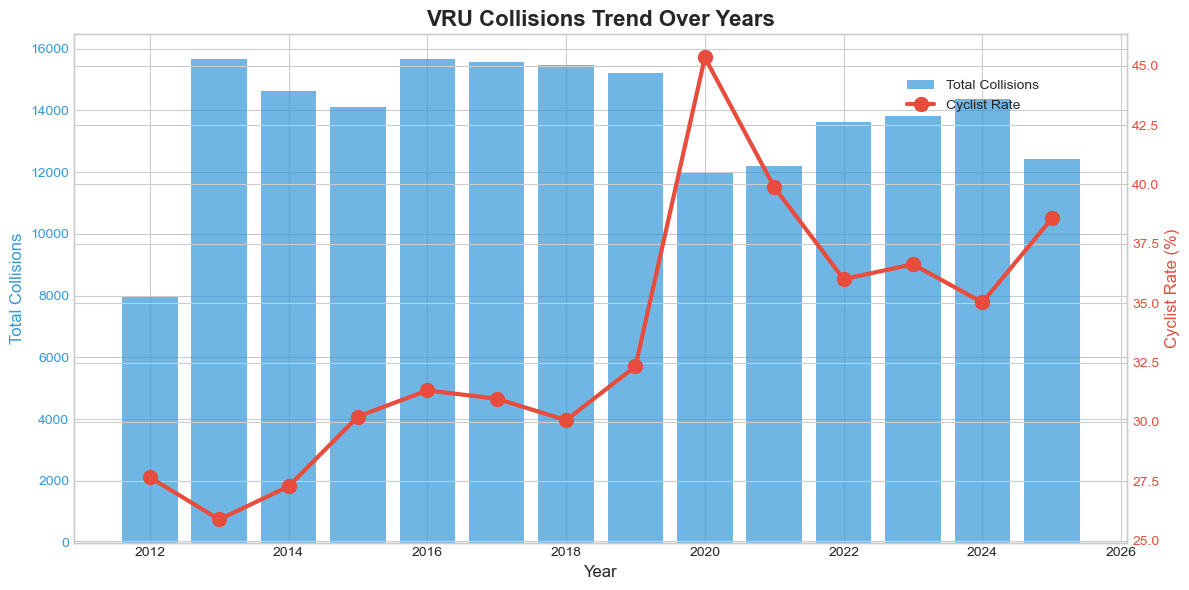

In [6]:
# Yearly trend
yearly = df.groupby('YEAR').agg({
    'TARGET': ['count', 'mean']
})
yearly.columns = ['Total', 'Cyclist_Rate']

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar for total collisions
color1 = '#3498db'
ax1.bar(yearly.index, yearly['Total'], color=color1, alpha=0.7, label='Total Collisions')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Collisions', color=color1, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color1)

# Line for cyclist rate
ax2 = ax1.twinx()
color2 = '#e74c3c'
ax2.plot(yearly.index, yearly['Cyclist_Rate']*100, 'o-', color=color2, linewidth=3, markersize=10, label='Cyclist Rate')
ax2.set_ylabel('Cyclist Rate (%)', color=color2, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('VRU Collisions Trend Over Years', fontsize=16, fontweight='bold')
fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.88))
plt.tight_layout()
plt.savefig('yearly_trend.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Top Contributing Factors

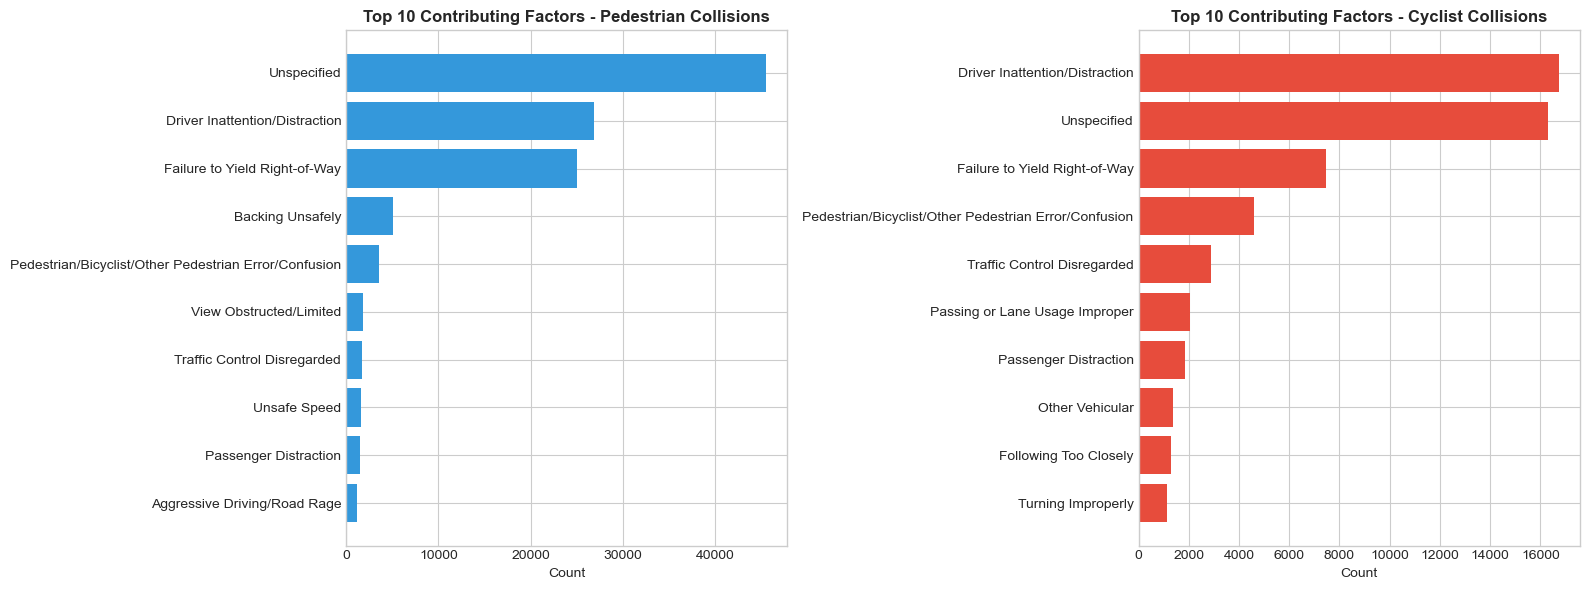

In [7]:
# Contributing factors analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top factors for pedestrians
ped_factors = df[df['TARGET']==0]['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(10)
axes[0].barh(ped_factors.index, ped_factors.values, color='#3498db')
axes[0].set_title('Top 10 Contributing Factors - Pedestrian Collisions', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Count')
axes[0].invert_yaxis()

# Top factors for cyclists
cyc_factors = df[df['TARGET']==1]['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(10)
axes[1].barh(cyc_factors.index, cyc_factors.values, color='#e74c3c')
axes[1].set_title('Top 10 Contributing Factors - Cyclist Collisions', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Count')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('contributing_factors.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary Statistics Table

In [8]:
# Create summary statistics
summary_data = {
    'Metric': [
        'Total Records',
        'Pedestrian Collisions', 
        'Cyclist Collisions',
        'Class Ratio (Ped:Cyc)',
        'Missing Coordinates (%)',
        'Boroughs Covered',
        'Date Range',
        'Best Model',
        'Best Accuracy',
        'Best ROC-AUC'
    ],
    'Value': [
        f"{len(df):,}",
        f"{(df['TARGET']==0).sum():,} ({(df['TARGET']==0).mean()*100:.1f}%)",
        f"{(df['TARGET']==1).sum():,} ({(df['TARGET']==1).mean()*100:.1f}%)",
        f"{(df['TARGET']==0).sum() / (df['TARGET']==1).sum():.2f}:1",
        f"{df['LATITUDE'].isna().mean()*100:.1f}%",
        f"{df['BOROUGH'].nunique()}",
        f"{df['CRASH_DATETIME'].min().strftime('%Y-%m')} to {df['CRASH_DATETIME'].max().strftime('%Y-%m')}",
        "XGBoost",
        "76.2%",
        "0.801"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("=" * 50)
print("PROJECT SUMMARY STATISTICS")
print("=" * 50)
print(summary_df.to_string(index=False))
print("=" * 50)

PROJECT SUMMARY STATISTICS
                 Metric              Value
          Total Records            192,707
  Pedestrian Collisions    128,796 (66.8%)
     Cyclist Collisions     63,911 (33.2%)
  Class Ratio (Ped:Cyc)             2.02:1
Missing Coordinates (%)               6.6%
       Boroughs Covered                  5
             Date Range 2012-07 to 2025-11
             Best Model            XGBoost
          Best Accuracy              76.2%
           Best ROC-AUC              0.801
